## Recognizing Locations from extracted text

Different methods to get the location the RTS broadcasts are about

In [ ]:
# ! pip install folium

In [1]:
from emv.db.dao import DataAccessObject
from sqlalchemy.sql import text
import pandas as pd
import numpy as np
import json
import folium
from collections import Counter
import os
import matplotlib.pyplot as plt
import seaborn as sns

from emv.client.get_content import get_features
from emv.utils import dataframe_from_hdf5

# Load data with query

In [ ]:
query = text("""SELECT * FROM feature WHERE feature_type = 'transcript+ner';""")
df = pd.DataFrame(DataAccessObject().fetch_all(query))

In [ ]:
loc_entities = []

for i, row in df.iterrows():
    try:
        for ent in row['data']['entities']:
            if ent[1] == 'LOC':
                loc_entities.append(ent[0].lower())
                # print(ent['text'])
        # print(row['data']['entities'])
    except KeyError:
        pass

In [ ]:
series = pd.Series(loc_entities).value_counts()

In [ ]:
all_locs = []
for s in series.items():
    all_locs.append(s)
print(all_locs)

## Match streets

In [ ]:
streets = []
for i, row in df.iterrows():
    try:
        for t in row['data']['transcript']:
            streets.append(t['t'])
        # row['data']['transcript'][0]['t']
    except KeyError:
        pass
    except TypeError:
        pass

In [ ]:
for i, row in df.iterrows():
    try:
        for t in row['data']['transcript']:
            if 'rue de' in t['t'].lower():
                print(t['t'])
        # row['data']['transcript'][0]['t']
    except KeyError:
        pass
    except TypeError:
        pass

In [ ]:
with open("data/geneva_streets.txt", "r") as f:
    streets = [x.strip() for x in f.readlines()]

In [ ]:
def replace_street(sent):
    corrected_street = sent.replace("ruedes", "rue des")
    corrected_street = corrected_street.replace("cheminde", "chemin de")
    corrected_street = corrected_street.replace("placedes", "place des")
    corrected_street = corrected_street.replace("placede", "place de")
    corrected_street = corrected_street.replace("routedes", "route des")
    corrected_street = corrected_street.replace("avenuede", "avenue de")
    corrected_street = corrected_street.replace("avenuedu", "avenue du")
    corrected_street = corrected_street.replace("ruede", "rue de")
    corrected_street = corrected_street.replace("quaidu", "quai du")
    corrected_street = corrected_street.replace("placedu", "place du")
    corrected_street = corrected_street.replace("promenadedu", "promenade du")
    corrected_street = corrected_street.replace("ruedu", "rue du")
    corrected_street = corrected_street.replace("routede", "route de")
    corrected_street = corrected_street.replace("passagedes", "passage des")
    corrected_street = corrected_street.replace("chemindes", "chemin des")
    corrected_street = corrected_street.replace("ruedes", "rue des")
    corrected_street = corrected_street.replace("squaredu", "square du")
    corrected_street = corrected_street.replace("passagede", "passage de")
    corrected_street = corrected_street.replace("promenade des", "promenade des ")
    return sent

In [ ]:
import spacy
from spacy.matcher import Matcher

# Load the French language model
nlp = spacy.load("fr_core_news_sm")

# Initialize the Matcher
matcher = Matcher(nlp.vocab)

street_names = ["Rue", "Chemin", "Place", "Avenue", "Boulevard", "Quai", "Promenade", "Route", "Square"]
connectors = ["des", "de", "du", "la", "le", "les", "l'", "d'", "au", "aux"]
second_connectors = ["l'", "d'", "la"]

# Define the pattern
pattern = [
    {"TEXT": {"IN": street_names}},
    {"TEXT": {"IN": connectors}, "OP": "?"},
    {"TEXT": {"REGEX": "^[a-zA-Z'-]+$"}, "OP": "+"},
]

# Add the pattern to the matcher
matcher.add("ADDRESS", [pattern])

# create a second pattern to match things like Rue de l'Hôtel-de-Ville or Chemin de la Gravière
pattern2 = [
    {"TEXT": {"IN": street_names}},
    {"TEXT": {"IN": connectors}, "OP": "?"},
    {"TEXT": {"IN": second_connectors}, "OP": "?"},
    {"TEXT": {"REGEX": "^[a-zA-Z-ôèéê]+$"}, "OP": "+"},

]
matcher.add("ADDRESS2", [pattern2])

# Process the sentences and get the matches
matched_streets = []

for street in streets:
    street = replace_street(street)
    # sentence = f"Hier, un accident s'est produit dans le sud de Genève, {street}, et 5 personnes ont été blessées. Le trafic est perturbé dans le secteur."
    sentence = street
    doc = nlp(sentence)
    matches = matcher(doc)

    # if matches are overlapped, we only keep the longest one
    if len(matches) > 1:
        matches = sorted(matches, key=lambda x: x[2]-x[1], reverse=True)
        matches = [matches[0]]

    for match_id, start, end in matches:
        span = doc[start:end]
        matched_streets.append(span.text)

matched_streets


In [ ]:
doc = nlp(sentence)
matches = matcher(doc)

# Load from API

In [2]:
features = get_features(feature_type='transcript+ner', max_features=None)

Authenticating...


/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://

[]
Retrieved 117728 features.


/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://

In [3]:
df = pd.DataFrame(features)

In [4]:
metadata = dataframe_from_hdf5("/mnt/g/rts/metadata", "rts_metadata")
metadata.reset_index(inplace=True)
metadata.rename(columns = {"mediaId": "rts_id"}, inplace=True)

In [5]:
df["rts_id"] = df["media_id"].apply(lambda x: x.split("-")[1])
df = df.merge(metadata, on='rts_id', how='left')

In [6]:
df["publishedDate"] = pd.to_datetime(df["publishedDate"])
df["year"] = df["publishedDate"].dt.year

In [7]:
df[["media_id", "rts_id", "year", "categoryName", "contentType", "title", "resume", "geoTheme"]].head()

,media_id,rts_id,year,categoryName,contentType,title,resume,geoTheme
0,rts-ZT001013,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",None
1,rts-ZT001013-M000,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",None
2,rts-ZT001013-M001,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",None
3,rts-ZT001013-M002,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",None
4,rts-ZT001013-M003,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",None


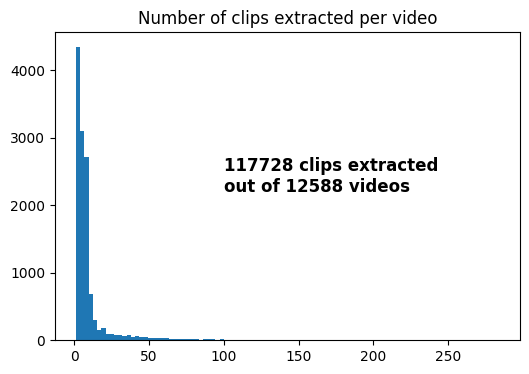

In [20]:
plt.figure(figsize=(6, 4))
df.rts_id.value_counts().hist(bins=100, grid = False)
plt.title("Number of clips extracted per video")
plt.text(100, 2200, f"{len(df)} clips extracted\nout of {len(df.rts_id.unique())} videos", fontdict={"size": 12, "weight": "bold"})
plt.show()

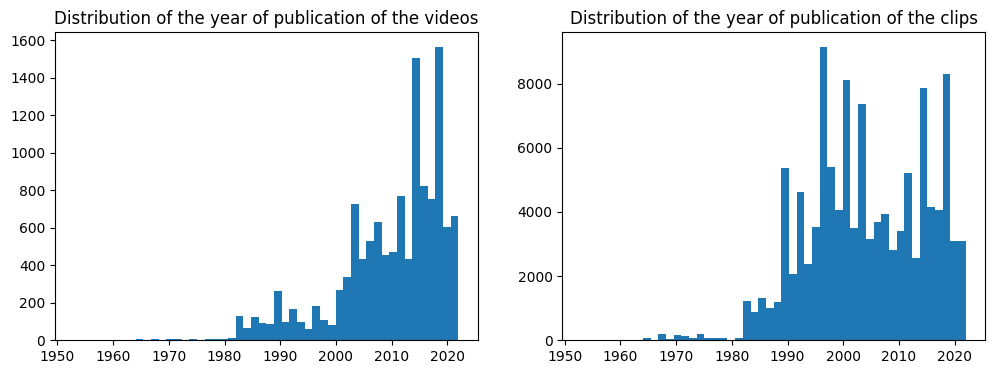

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df.groupby("rts_id").year.mean().hist(bins=50, ax=axs[0], grid = False)
axs[0].set_title("Distribution of the year of publication of the videos")
df.year.hist(bins=50, ax=axs[1], grid = False)
axs[1].set_title("Distribution of the year of publication of the clips")
plt.show()

## Extracting locations

In [29]:
def get_entities(data):
    entities = []
    if "entities" in data.keys():
        entities = data["entities"]
    else:
        entities = [t.get("entities", []) for t in data.get("transcript", [])]
        entities = [e for sublist in entities for e in sublist]
    
    return entities

In [30]:
df["entities"] = df["data"].apply(get_entities)

In [31]:
df["locations"] = df["entities"].apply(lambda x: [e[0] for e in x if e[1] == "LOC" and len(e[0]) > 2])

## Map of Switzerland

In [70]:
locations = df["locations"].explode().value_counts()
locations = pd.DataFrame(locations).reset_index().rename(columns={"locations":"location"})
locations[:10]

,location,count
0,Suisse,15534
1,Genève,5672
2,Lausanne,2443
3,Est,2368
4,État,2277
5,Valais,2055
6,Berne,2055
7,Suisses,1973
8,Europe,1972
9,Confédération,1729


In [83]:
locations = df[["locations", "year"]].explode("locations").dropna().groupby("locations").agg(list).reset_index()
locations["count"] = locations["year"].apply(len)
locations["year"] = locations.year.map(lambda x: Counter(x))
locations = locations.sort_values("count", ascending=False)
locations.head(10)

,locations,year,count
15742,Suisse,"{2011: 265, 2010: 407, 2014: 440, 2015: 398, 2...",15534
6592,Genève,"{2010: 153, 2015: 157, 2016: 123, 2017: 126, 2...",5672
9152,Lausanne,"{2011: 60, 2015: 76, 2016: 185, 2019: 85, 2000...",2443
5540,Est,"{2011: 53, 2010: 52, 2015: 52, 2014: 41, 2016:...",2368
22438,État,"{2015: 48, 2016: 79, 2017: 67, 2018: 66, 2019:...",2277
1906,Berne,"{2014: 36, 2016: 38, 2017: 51, 2019: 65, 2000:...",2055
17086,Valais,"{2010: 53, 2017: 70, 2018: 58, 2019: 61, 2000:...",2055
15827,Suisses,"{2014: 48, 2015: 33, 2016: 33, 2018: 46, 2019:...",1973
5685,Europe,"{2014: 56, 2015: 56, 2016: 69, 2018: 65, 2019:...",1972
4136,Confédération,"{2016: 33, 2018: 76, 2019: 42, 2000: 108, 2001...",1729


In [86]:
with open("../emv/features/cities.json", "r") as f:
    cities = json.load(f)

In [88]:
cities = pd.DataFrame([{"locations":k, "lon":float(v[0]), "lat":float(v[1])} for k,v in cities.items() if len(v) == 2])

In [89]:
cities.head()

,locations,lon,lat
0,Bassecourt,47.350000,7.233333
1,Barberêche,46.850000,7.166667
2,Chésopelloz,46.800000,7.083333
3,Büren zum Hof,47.095556,7.513611
4,Cresciano,46.283333,9.000000


In [90]:
found_cities = pd.merge(locations, cities, on="locations", how="left").dropna(subset = ["lat", "lon"])
found_cities

,locations,year,count,lon,lat
1,Genève,"{2010: 153, 2015: 157, 2016: 123, 2017: 126, 2...",5672,46.200000,6.150000
2,Lausanne,"{2011: 60, 2015: 76, 2016: 185, 2019: 85, 2000...",2443,46.533333,6.633333
5,Berne,"{2014: 36, 2016: 38, 2017: 51, 2019: 65, 2000:...",2055,46.947980,7.447430
10,Zurich,"{2015: 63, 2016: 131, 2018: 40, 2000: 61, 2001...",1631,47.374444,8.541111
11,Neuchâtel,"{2010: 37, 2014: 38, 2016: 45, 2018: 47, 2019:...",1593,46.990278,6.930556
...,...,...,...,...,...
22223,Paradiso,{2000: 1},1,45.983333,8.950000
22373,Morgarten,{1989: 1},1,47.105091,8.640683
22420,Meyrin,{2003: 1},1,46.232220,6.079110
22563,Neuhausen,{1989: 1},1,47.685790,8.614740


In [ ]:
# Create a base map centered around Switzerland
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8)
size_multiplier = 1
# Add city points to the map
for index, row in found_cities.iterrows():
    folium.CircleMarker(
        location=(row['lon'], row['lat']),
        radius=np.sqrt(row['count'] / np.pi) * size_multiplier,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        tooltip=row['locations'] + ': ' + str(row['count']) + ' occurrences'
    ).add_to(m)

m

## Evolution over time

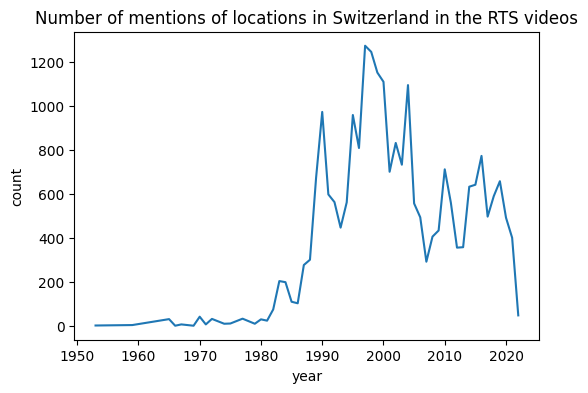

In [146]:
n_mentions_per_year = found_cities.year.sum()
n_mentions_per_year = pd.DataFrame(n_mentions_per_year.items(), columns=["year", "count"])
n_mentions_per_year = n_mentions_per_year.sort_values("year")

plt.figure(figsize=(6, 4))
sns.lineplot(data=n_mentions_per_year, x="year", y="count")
plt.title("Number of mentions of locations in Switzerland in the RTS videos")
plt.show()

In [147]:
n_mentions_per_year_dict = n_mentions_per_year.set_index("year").to_dict()["count"]
found_cities["relative_counts"] = found_cities.year.map(lambda x: {k:v / n_mentions_per_year_dict[k] for k,v in x.items()})

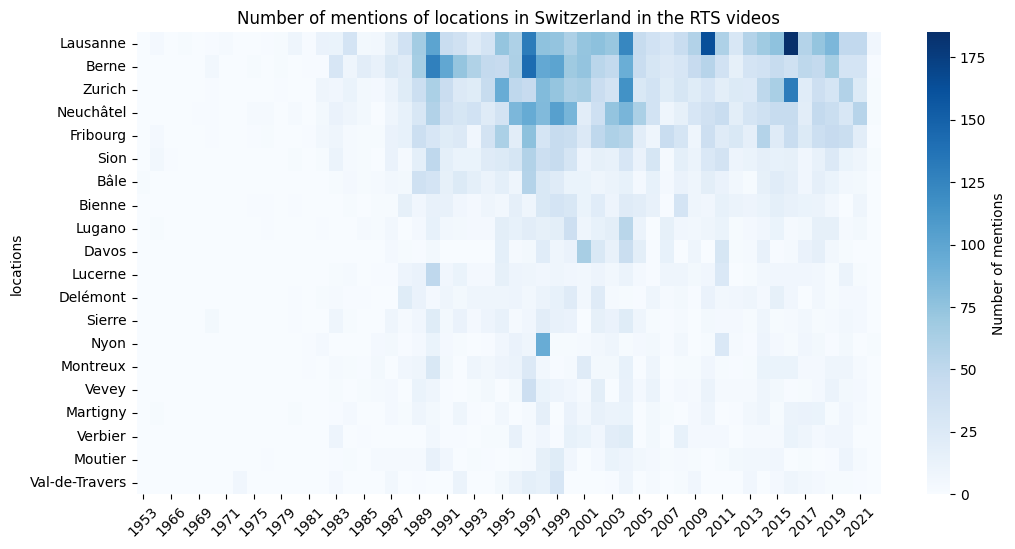

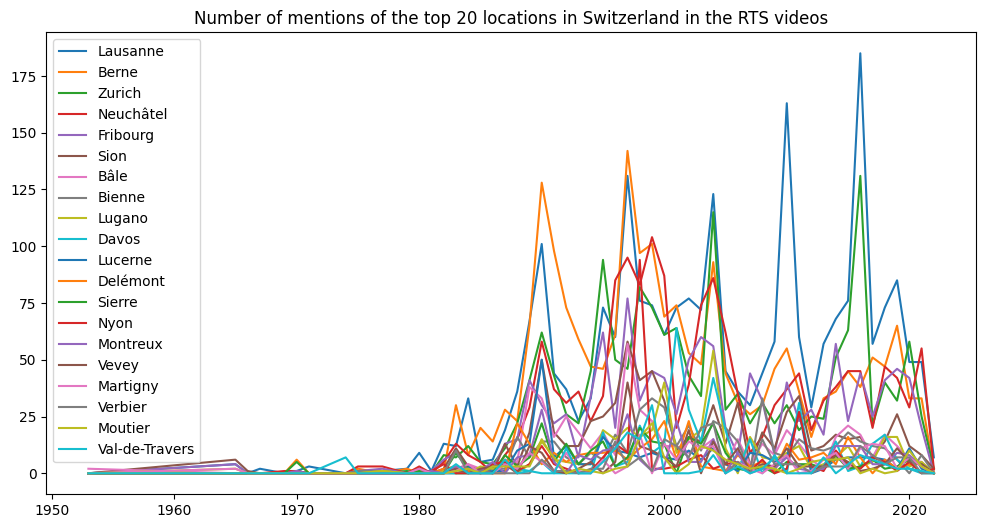

In [152]:
top_N = 20
top_cities = found_cities[1:top_N + 1]
counts_per_year = pd.DataFrame(top_cities.year.tolist(), index=top_cities.locations).fillna(0)
counts_per_year = counts_per_year.T.sort_index().T

plt.figure(figsize=(12, 6))
sns.heatmap(counts_per_year, cmap="Blues", cbar_kws={'label': 'Number of mentions'})
plt.title("Number of mentions of locations in Switzerland in the RTS videos")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
for loc,mentions in counts_per_year.iterrows():
    plt.plot(mentions.index, mentions.values, label=loc)
plt.legend()
plt.title(f"Number of mentions of the top {len(counts_per_year)} locations in Switzerland in the RTS videos")
plt.show()